## Time Series Analysis Assignment

### Evaluation of Historical Monthly Data CO2 Data 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set()
import pmdarima as pm

In [2]:
data = pd.read_csv('co2_mm_mlo.csv')
data.head()

,year,month,day,date,decimal date,average,interpolated,trend,ndays,Unnamed: 9
0,1958,3,15,1958-03-15,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,15,1958-04-15,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,15,1958-05-15,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,15,1958-06-15,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,15,1958-07-15,1958.5370,315.86,315.18,-1,-9.99,-0.99


In [3]:
# check data types
data.dtypes

year              int64
month             int64
day               int64
date             object
decimal date    float64
average         float64
interpolated    float64
trend             int64
ndays           float64
Unnamed: 9      float64
dtype: object

In [4]:
# convert date to a datetime object
data['date'] = pd.to_datetime(data['date'])

In [5]:
# note: will build a data df from year, mnth, day data. day specified as the 15th of each month
co2_data = data[['date','average']]
co2_data.set_index(data.date, inplace = True)
co2_data.drop('date', axis = 1)
co2_data.head()

,date,average
date,,
1958-03-15,1958-03-15,315.70
1958-04-15,1958-04-15,317.45
1958-05-15,1958-05-15,317.51
1958-06-15,1958-06-15,317.24
1958-07-15,1958-07-15,315.86


In [6]:
# check data types - date now a datetime
co2_data.dtypes

date       datetime64[ns]
average           float64
dtype: object

#### Time Series Plotting

Text(0, 0.5, 'CO2 (ppm)')

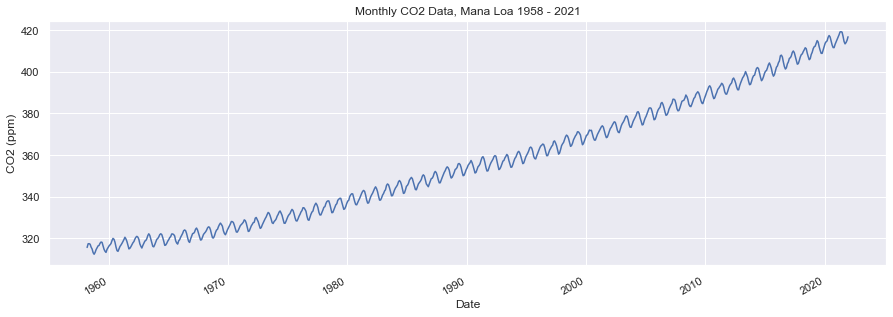

In [7]:
# will plot out the time series 
plt.figure(figsize = (15,5))
co2_data['average'].plot()
plt.title('Monthly CO2 Data, Mana Loa 1958 - 2021')
plt.xlabel('Date')
plt.ylabel('CO2 (ppm)')

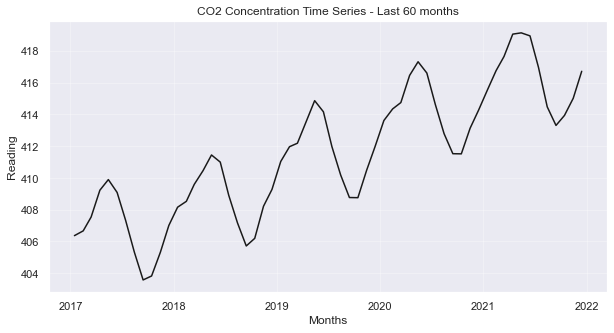

In [8]:
# can see that the time series appears to have a definite upward trend, some autocorrelation, and periods of seasonality
# we will now take a closer look, using the utility functions from the previous tutorial, to 'zoom in' on sections of a large time series

def get_n_last_months(df, series_name, n_months):
    """
    Extract last n_months of a monthly time series
    """
    
    return df[series_name][-n_months:] 

def plot_n_last_months(df, series_name, n_months):
    """
    Plot last n_months of a monthly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_months(df, series_name, n_months), 'k-')
    plt.title('CO2 Concentration Time Series - Last {0} months'
              .format(n_months))
    plt.xlabel('Months')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)
    
# lets look at the last 5 years (60 months) of data
plot_n_last_months(co2_data, 'average', 60)

In [9]:
# again, shows trend, seasonality, and potential autocorrelation
# based on both plots, it should be assumed that this is indeed an additive time series - as the magnitude of the seasonality compoent seems independent of trend
# seems the frequency of the seasonal component is approximately annual (ie: 12 months)

#### Time Series Decomposition

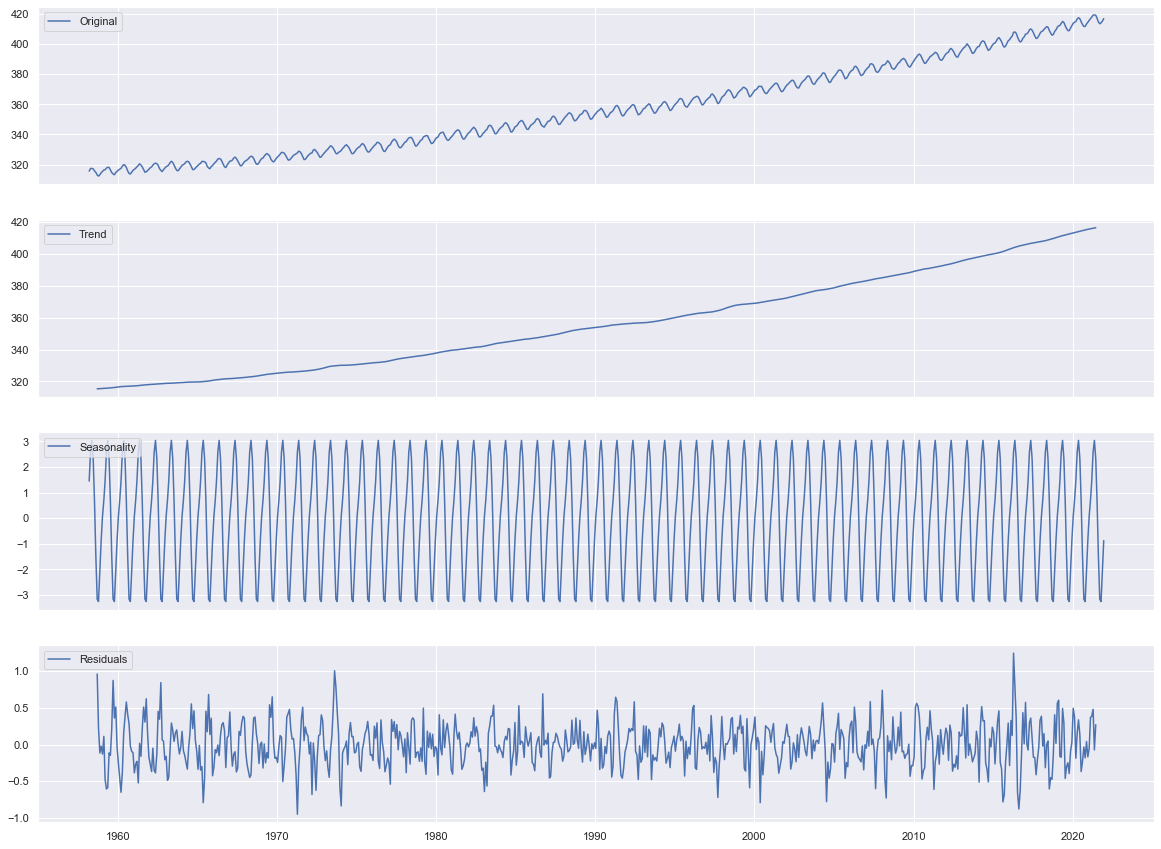

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=co2_data['average'], model='additive', period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

# plotting the decomposition
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(15)
fig.set_figwidth(20)

axes[0].plot(co2_data['average'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [11]:
# here, the decomposition does a decent job of breaking down the time series. It appears that there is some autocorrelation potentially 'baked-in' as part of the residuals though

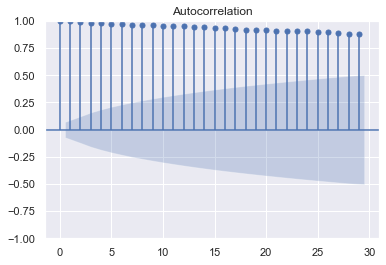

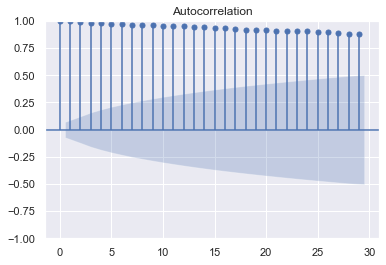

In [12]:
# checking autocorrelation - as we can see, there is a long history of autocorrelation (significant to > 30 lags)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(co2_data['average'])

#### Stationarity Check

Given the time series has a changing mean over time (trend), a seasonal component (seasonality), and high autocorrelation, it is certainly not stationary. howeer, we will confirm this with various tests

Text(0, 0.5, 'CO2 (ppm)')

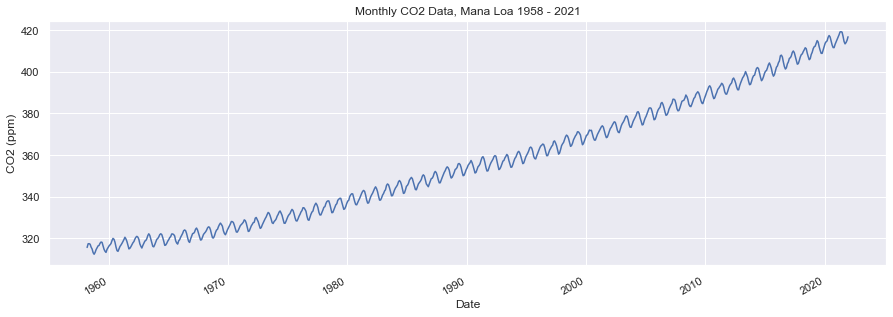

In [13]:
# Replotting the run sequence plot - shows a trend + seasonal component (non-stationary)
# will plot out the time series 
plt.figure(figsize = (15,5))
co2_data['average'].plot()
plt.title('Monthly CO2 Data, Mana Loa 1958 - 2021')
plt.xlabel('Date')
plt.ylabel('CO2 (ppm)')

In [14]:
# chunking - will split time series into chunks and compare means/variances
# size of co2 data average data set: 
print('Size of Series: ', co2_data['average'].size)

# split chunks - will use only 760 readings so things divide evenly into 10 chunks
arr = np.array(co2_data['average'][0:760])
chunks = np.split(arr, indices_or_sections=10)
print('Number of chunks: ', len(chunks))

Size of Series:  766
Number of chunks:  10


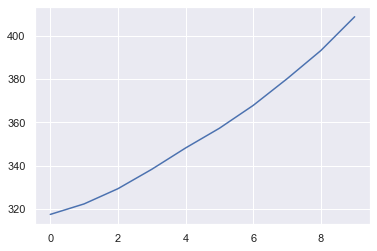

In [15]:
# check mean of chunks - mean rising indicates non-stationarity
np.mean(chunks, axis=1)
plt.plot(np.mean(chunks, axis=1))

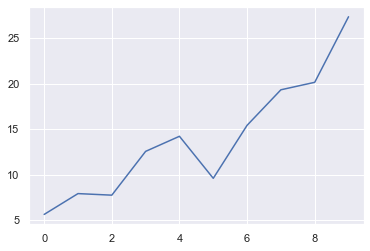

In [16]:
# check variance of chunks - changes in variance (heteroscedasticity) indicate non-stationarity
np.var(chunks, axis = 1)
plt.plot(np.var(chunks, axis=1))

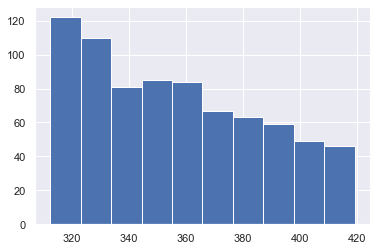

In [17]:
# histogram plot - will plot histogram to see if terms are roughly normally distributed. We can see that the data is nowhere near normal distribution, indicating non-stationarity
co2_data['average'].hist();

In [18]:
# will do the statistical Augmented Dickey-Fuller test to check for stationarity

from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(co2_data['average'])
print('ADF: ', adf)
print('p-value: ', pvalue)
print('Observations: ', nobs)
print('Critical Values: ', critical_values)

ADF:  5.380000880062172
p-value:  1.0
Observations:  745
Critical Values:  {'1%': -3.4391580196774494, '5%': -2.8654273226340554, '10%': -2.5688400274762397}


As we can see, by all measures, this is a non-stationary series

#### Making Time Series Stationary w/ Transformations

In [19]:
# previously, we seasonally decomposed the time series 

ss_decomposition = seasonal_decompose(x=co2_data['average'], model='additive', period=6)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

In [20]:
# lets look at the residual values, leaving out the NaN values:
print(estimated_residual[3:-3])

date
1958-06-15    0.271930
1958-07-15   -0.127991
1958-08-15    0.469581
1958-09-15   -0.214107
1958-10-15   -1.278496
                ...   
2021-05-15    0.749917
2021-06-15    0.875263
2021-07-15    0.037009
2021-08-15   -0.922086
2021-09-15   -1.079107
Name: resid, Length: 760, dtype: float64


In [21]:
# now lets run the ADFuller test on the residuals
adf_2, pvalue_2, usedlag_2, nobs_2, critical_values_2, icbest_2 = adfuller(estimated_residual[3:-3])
print('ADF: ', adf_2)
print('p-value: ', pvalue_2)
print('Observations: ', nobs_2)
print('Critical Values: ', critical_values_2)

ADF:  -9.193691444159366
p-value:  2.09015182428935e-15
Observations:  739
Critical Values:  {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


Based on the ADF, if we remove trend & seasonality, then the time series will be stationary

#### Analysis #1 - Time Series Exponential Smoothing

In [22]:
# given the relative size of the time series (766 entries), we will hold back the last 60 months of data (5 years) in order to attempt to fit an exponential smoothing algorithm
# first, will define the mean square error function from the previous labs

def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse


In [23]:
# define training/testing splits

train = np.array(co2_data['average'][0:-60])
test = np.array(co2_data['average'][-60:])

##### Simple Average Smoothing

In [24]:
# find mean of series
co2_avg = np.mean(co2_data['average'])

# create array of mean value equal to length of time array
simple_avg_preds = np.full(shape=len(test), fill_value=co2_avg, dtype='float')

# mse
simple_mse = mse(test, simple_avg_preds)

# results
print("Predictions: ", simple_avg_preds)
print("MSE: ", simple_mse)

Predictions:  [356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389
 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389 356.7897389]
MSE:  180960.8238346385


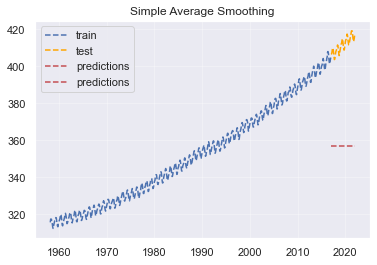

In [25]:
# plotting the results
plt.plot(co2_data['date'][0:-60], train, 'b--', label="train")
plt.plot(co2_data['date'][-60:], test, color='orange', linestyle="--", label="test")
plt.plot(co2_data[-60:], simple_avg_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Average Smoothing")
plt.grid(alpha=0.3);

In [26]:
# as we can see, this is a pretty terrible/crude prediction/smoothing, but a decent baseline nonetheless. It is essentially applying the average value as a constant 

##### Single Exponential Smoothing

In [27]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999
 404.63999999 404.63999999 404.63999999 404.63999999 404.63999999]
MSE:  3828.934711389207


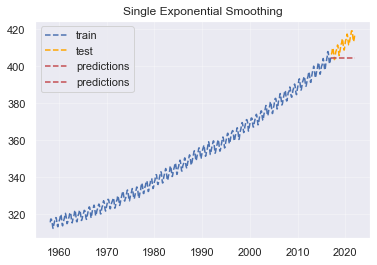

In [28]:
# plotting the results
plt.plot(co2_data['date'][0:-60], train, 'b--', label="train")
plt.plot(co2_data['date'][-60:], test, color='orange', linestyle="--", label="test")
plt.plot(co2_data[-60:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

In [29]:
# as we can see, it is getting a little better/closer to predicting, but still a high error. It is essentially extrapolating the last value as a constant

##### Double Exponential Smoothing

In [30]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [405.5600001  406.48000018 407.40000025 408.32000033 409.24000041
 410.16000048 411.08000056 412.00000064 412.92000071 413.84000079
 414.76000087 415.68000094 416.60000102 417.5200011  418.44000117
 419.36000125 420.28000133 421.2000014  422.12000148 423.04000156
 423.96000164 424.88000171 425.80000179 426.72000187 427.64000194
 428.56000202 429.4800021  430.40000217 431.32000225 432.24000233
 433.1600024  434.08000248 435.00000256 435.92000263 436.84000271
 437.76000279 438.68000286 439.60000294 440.52000302 441.4400031
 442.36000317 443.28000325 444.20000333 445.1200034  446.04000348
 446.96000356 447.88000363 448.80000371 449.72000379 450.64000386
 451.56000394 452.48000402 453.40000409 454.32000417 455.24000425
 456.16000432 457.0800044  458.00000448 458.92000455 459.84000463]
MSE:  36697.727517494815


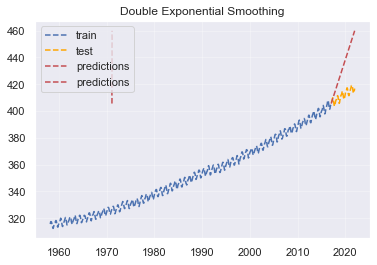

In [31]:
# plotting the results
plt.plot(co2_data['date'][0:-60], train, 'b--', label="train")
plt.plot(co2_data['date'][-60:], test, color='orange', linestyle="--", label="test")
plt.plot(co2_data[-60:], double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

In [32]:
# as we can see, the predictions are getting better, but still aren't quite there. It is now forecasting/predicting off the slope of the line of the last reading

##### Triple Exponential Smoothing

In [33]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train, trend="additive", seasonal="additive", seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [405.87863702 406.71272242 407.60420538 409.03061786 409.53968271
 408.71443697 407.12067416 405.12630739 403.8260435  404.12427619
 405.62101699 407.05999631 408.15619851 408.99028391 409.88176686
 411.30817935 411.8172442  410.99199846 409.39823565 407.40386887
 406.10360498 406.40183768 407.89857847 409.3375578  410.43376
 411.26784539 412.15932835 413.58574083 414.09480569 413.26955995
 411.67579714 409.68143036 408.38116647 408.67939917 410.17613996
 411.61511929 412.71132148 413.54540688 414.43688984 415.86330232
 416.37236717 415.54712144 413.95335862 411.95899185 410.65872796
 410.95696066 412.45370145 413.89268077 414.98888297 415.82296837
 416.71445133 418.14086381 418.64992866 417.82468292 416.23092011
 414.23655334 412.93628945 413.23452214 414.73126294 416.17024226]
MSE:  18.06869843019651


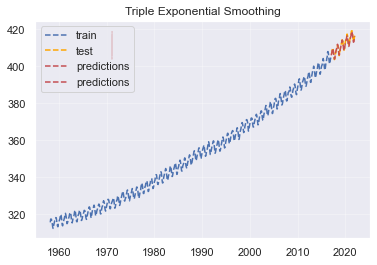

In [34]:
# plotting the results
plt.plot(co2_data['date'][0:-60], train, 'b--', label="train")
plt.plot(co2_data['date'][-60:], test, color='orange', linestyle="--", label="test")
plt.plot(co2_data[-60:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

In [35]:
# as we can see, a Triple exponential smoothing algorithm takes seasonality and trend into account quite well, and did an exceleltn job of fitting/predicting CO2 levels on the hold out set
# which was the last 5 years of CO2 data. It fit wil a MSE of ~ 18, which is pretty fantastic. 

# as a predictive algorithm, this would do well as a simple model

#### Analysis #2 - SARIMA Modeling

We know, from previous plotting of the run sequence, as well as time series decomposition and autocorrelation plotting, that our time series has a fair amount of autocorrelation built into it. for this reason, it is best to use a Seasonal, Autoregressive, Integrated, moving Average (SARIMA) model in an attempt to model the time series. 

One of the challenges here, given the significance of autocorrelation found in the simple plot (see below) is figuring out the best/most appropriate lag structure

In [36]:
# define helper plot function for visualization
def plots(data, lags=None):
    plt.figure(figsize = (20, 8))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

C:\Users\iaustin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


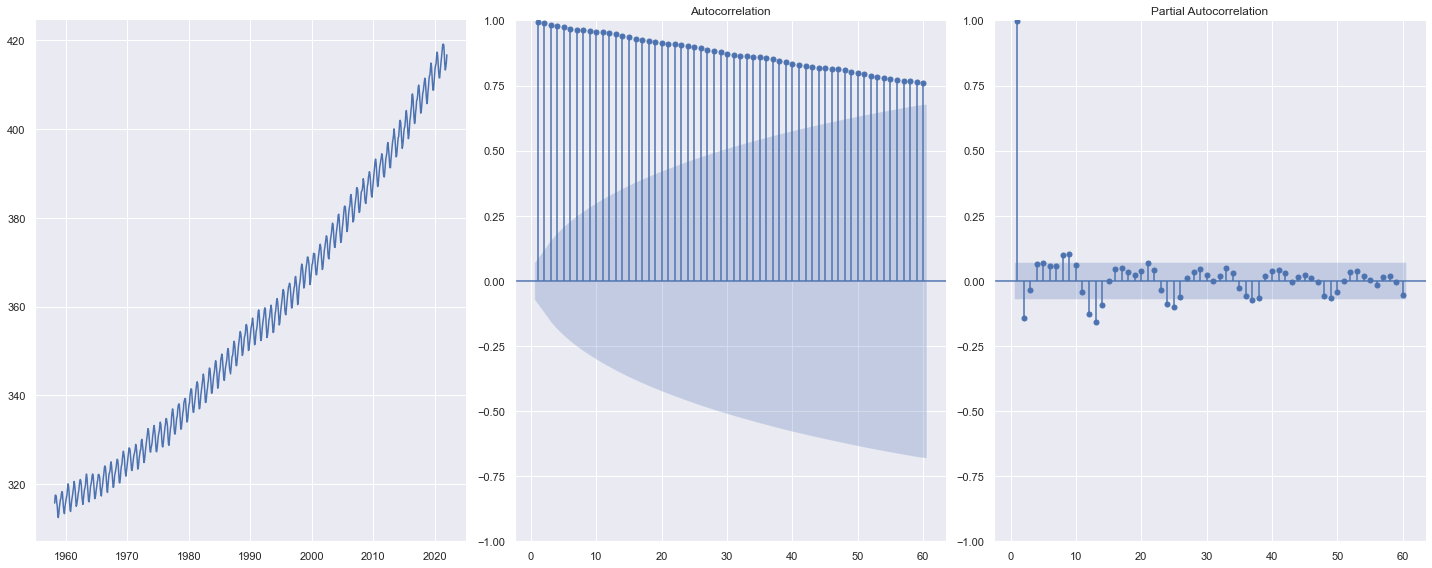

In [37]:
# helper plot for monthly CO2 - let's look at the last 5 yrs/60 months
plots(co2_data.average, lags=60)

In [38]:
# as we can see, the current series in not stationary (autocorrelation is slowly decaying, indicating non-stationarity via the Box-Jenkins method).
# It looks as if some differencing will need to be applied to the series (will use 1st order differencing)

co2_data['avg - diff1'] = co2_data['average'].diff()

# remove NA terms from data frame
co2_data = co2_data.dropna()

co2_data.head()

C:\Users\iaustin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,average,avg - diff1
date,,,
1958-04-15,1958-04-15,317.45,1.75
1958-05-15,1958-05-15,317.51,0.06
1958-06-15,1958-06-15,317.24,-0.27
1958-07-15,1958-07-15,315.86,-1.38
1958-08-15,1958-08-15,314.93,-0.93


C:\Users\iaustin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


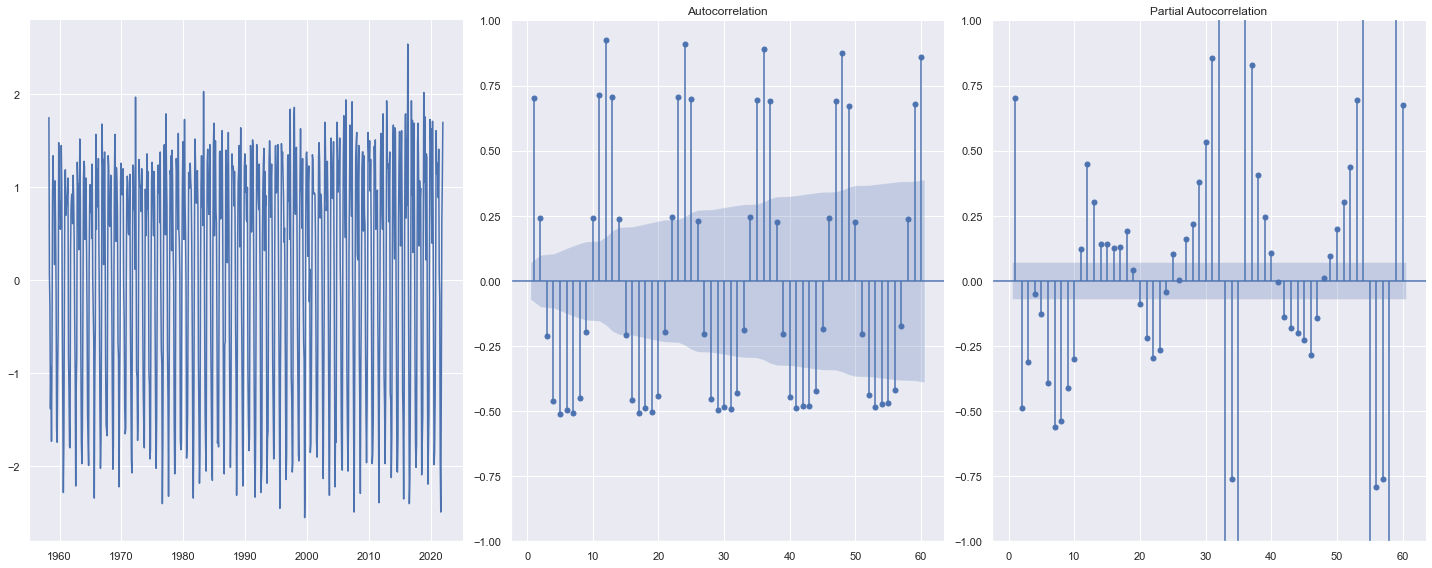

In [39]:
# now running helper plot again
plots(co2_data['avg - diff1'], lags=60)

In [40]:
# now the autocorrelation plot is alternating positive/negative and decaying to zero. This is an autoregressive model, which will require using the pacf curve to identify order. 
# The pacf curve is all over the place after differencing. 
# Based on this, will liekly run the auto_arima function as  ahelper to determine the best p,d,q/P,D,Q parametersm, using AIC/BIC to determine
# will use a training set, holding out the last 60 months for test/comparison

stepwise_model = pm.auto_arima(co2_data['average'][:-60], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=372.082, Time=2.07 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1602.023, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.131, Time=1.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1188.400, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2720.884, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=697.462, Time=0.32 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=375.771, Time=5.48 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=534.072, Time=2.16 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=439.769, Time=6.18 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=371.898, Time=2.96 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=698.739, Time=0.66 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.37 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC

In [41]:
# print out the 'best' selected paramerters
print('auto-fit order: :', stepwise_model.order)
print('auto-fit seasonal_order: :', stepwise_model.seasonal_order)

auto-fit order: : (1, 0, 3)
auto-fit seasonal_order: : (0, 1, 1, 12)


In [42]:
# the stepwise model shows the best combination p,d,q/P,D,Q of 1,0,3/0,1,1,12

from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=0)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

In [43]:
# predicting 5 years/60 months into the future from CO2 data 60 months ago:
s = co2_data['average'][:-60]
preds = future_preds_df(stepwise_model,s, 60)

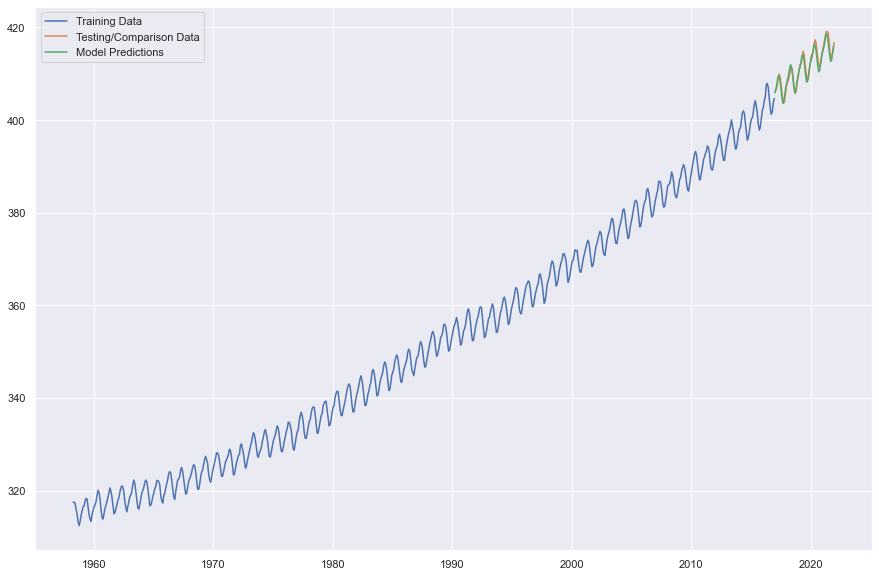

In [44]:
# plotting predictions vs time series data:
plt.figure(figsize = (15, 10))
plt.plot(s, label = 'Training Data')
plt.plot(co2_data['average'][-60:], label = 'Testing/Comparison Data')
plt.plot(preds, label = 'Model Predictions')
plt.legend()
plt.show()

As we can see,,the current model, when compared to a holdout set of the last 5 yrs/60 months of data, does a pretty great job of predicting values in the series

In [45]:
# numerical evaluation

holdout_set = co2_data['average'][-60:].to_list()
preds['holdout data'] = holdout_set
preds = preds.rename(columns = {0: 'Preds'})
preds

,Preds,holdout data
2017-01-01,405.847168,406.36
2017-02-01,406.641681,406.66
2017-03-01,407.591728,407.53
2017-04-01,409.084749,409.22
2017-05-01,409.710973,409.89
2017-06-01,408.925079,409.08
2017-07-01,407.248395,407.33
2017-08-01,405.123919,405.32
2017-09-01,403.720782,403.57
2017-10-01,403.991404,403.82


In [46]:
preds['absolute error'] = np.abs(preds['Preds'] - preds['holdout data'])
preds['squared error'] = preds['absolute error'] ** 2
preds

,Preds,holdout data,absolute error,squared error
2017-01-01,405.847168,406.36,0.512832,0.262997
2017-02-01,406.641681,406.66,0.018319,0.000336
2017-03-01,407.591728,407.53,0.061728,0.003810
2017-04-01,409.084749,409.22,0.135251,0.018293
2017-05-01,409.710973,409.89,0.179027,0.032051
2017-06-01,408.925079,409.08,0.154921,0.024000
2017-07-01,407.248395,407.33,0.081605,0.006659
2017-08-01,405.123919,405.32,0.196081,0.038448
2017-09-01,403.720782,403.57,0.150782,0.022735
2017-10-01,403.991404,403.82,0.171404,0.029379


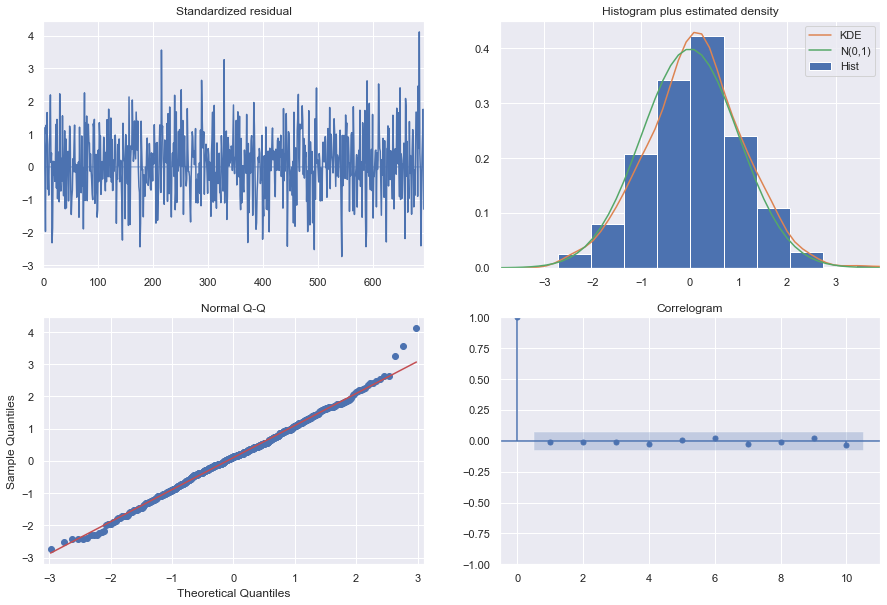

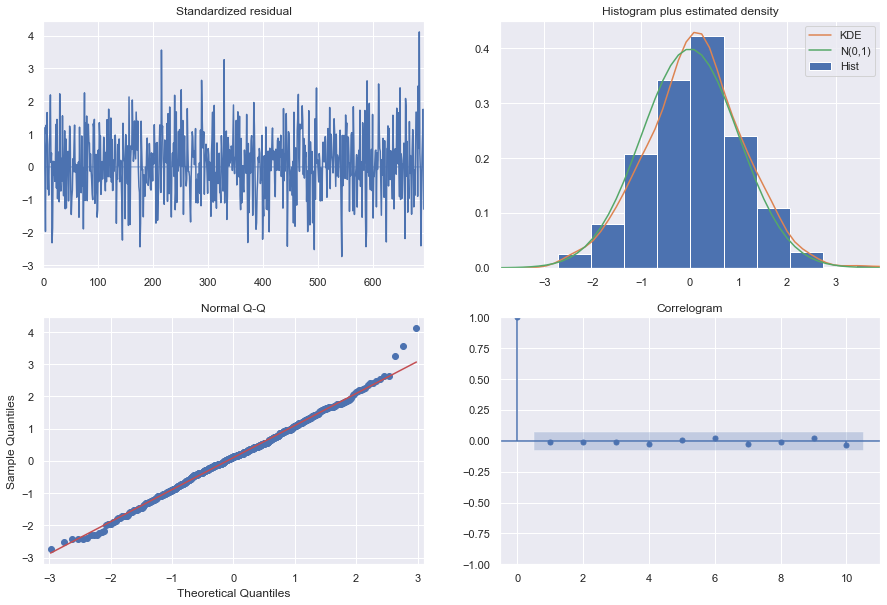

In [47]:
# looking at model diagnostics
stepwise_model.plot_diagnostics(figsize = (15, 10))

The SARIMA model witjh parameters: 

p: 1 (AR order 1) <br>
d: 0 (no differencing) <br>
q: 3 (MA order 3) <br>

P: 0 (AR order 0) <br>
D: 1 (single differencing) <br>
Q: 1 (MA order 1) <br>
Seasonality: 12 months <br>

Worked especially well in modeling the forward time series, when holding out the last 60 months of data (5  yesrs). small errors, of less than 1/8 of a percentae point were observed. This is an excellently performing model, with high confidence in predicting going forward

#### Analysis #3 - Facebook Prophet

In [48]:
from prophet import Prophet

In [49]:
# set plotting parameters
plt.rcParams['figure.figsize'] = [14, 4]

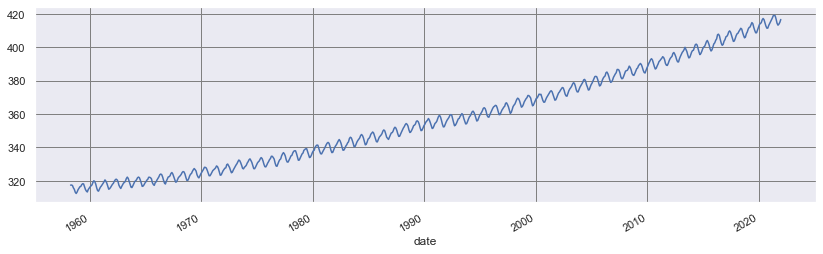

In [50]:
# plot data for average CO2
co2_data['average'].plot()
plt.grid(color = 'grey', linestyle = '-')

In [51]:
# organize CO2 Data so it has 2 columns ds (date) and y (average)
co2_data_p = co2_data.drop(['date', 'avg - diff1'], axis = 1)

In [52]:
co2_data_p.rename(columns = {'average': 'y'}, inplace = True)

In [53]:
co2_data_p.reset_index(inplace = True)

In [54]:
co2_data_p.rename(columns = {'date': 'ds'}, inplace = True)

In [55]:
co2_data_p

,ds,y
0,1958-04-15,317.45
1,1958-05-15,317.51
2,1958-06-15,317.24
3,1958-07-15,315.86
4,1958-08-15,314.93
...,...,...
760,2021-08-15,414.47
761,2021-09-15,413.30
762,2021-10-15,413.93
763,2021-11-15,415.01


In [56]:
# like in previous iterations, will hold back 60 months of data for comparison to model predictive outputs
train = co2_data_p[:-60]
holdout = co2_data_p[-60:]

In [57]:
# fit model on training data
model = Prophet()
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
# forecast 5 yrs/60 months into future to match other models
# prophet requires a blank dataframe to input predictions
# will also provide blank set for dates within dataset to allow for fit
future = model.make_future_dataframe(periods=60, freq='M', include_history=True)
future.tail()

,ds
760,2021-07-31
761,2021-08-31
762,2021-09-30
763,2021-10-31
764,2021-11-30


In [59]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
760,2021-07-31,414.224971,410.168506,415.379773,411.434807,416.623598,-1.228683,-1.228683,-1.228683,-1.228683,-1.228683,-1.228683,0.0,0.0,0.0,412.996288
761,2021-08-31,414.408080,409.655517,415.011796,411.549029,416.886047,-1.964275,-1.964275,-1.964275,-1.964275,-1.964275,-1.964275,0.0,0.0,0.0,412.443805
762,2021-09-30,414.585283,407.930078,413.426823,411.649578,417.139075,-3.632986,-3.632986,-3.632986,-3.632986,-3.632986,-3.632986,0.0,0.0,0.0,410.952297
763,2021-10-31,414.768392,408.806430,414.529900,411.745306,417.402074,-2.858432,-2.858432,-2.858432,-2.858432,-2.858432,-2.858432,0.0,0.0,0.0,411.909960
764,2021-11-30,414.945595,410.814711,416.723713,411.846082,417.656751,-0.989041,-0.989041,-0.989041,-0.989041,-0.989041,-0.989041,0.0,0.0,0.0,413.956554


In [60]:
# will print forecast dataframe with 
results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
results

,ds,yhat,yhat_lower,yhat_upper
0,1958-04-15,317.595782,317.075145,318.124563
1,1958-05-15,318.120420,317.610309,318.643595
2,1958-06-15,317.492791,316.958994,318.019582
3,1958-07-15,315.960762,315.378312,316.473097
4,1958-08-15,313.870890,313.381334,314.394258
...,...,...,...,...
760,2021-07-31,412.996288,410.168506,415.379773
761,2021-08-31,412.443805,409.655517,415.011796
762,2021-09-30,410.952297,407.930078,413.426823
763,2021-10-31,411.909960,408.806430,414.529900


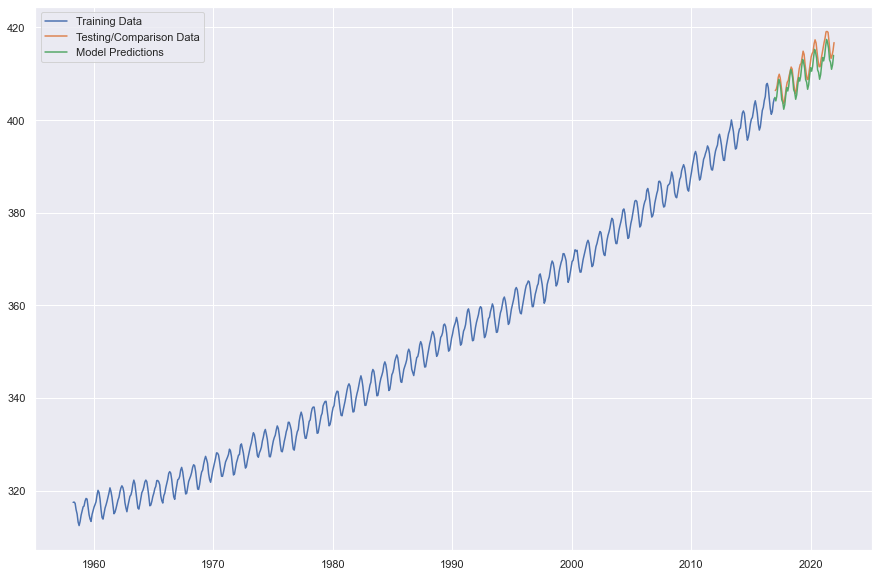

In [61]:
# plot results - will only plot opredicted (yhat) values, without confidence intervals to compare to holdout data set
plt.figure(figsize = (15, 10))
plt.plot(train['ds'], train['y'], label = 'Training Data')
plt.plot(holdout['ds'], holdout['y'], label = 'Testing/Comparison Data')
plt.plot(results['ds'][-60:], results['yhat'][-60:], label = 'Model Predictions')
plt.legend()
plt.show()

In [62]:
# numerically again
r = results[['ds', 'yhat']][-60:]
s = pd.merge(holdout, r, left_index = True, right_index = True)

s['absolute error'] = np.abs(s['y'] - s['yhat'])
s['squared error'] = s['absolute error'] ** 2

In [63]:
s

,ds_x,y,ds_y,yhat,absolute error,squared error
705,2017-01-15,406.36,2016-12-31,404.868859,1.491141,2.223503
706,2017-02-15,406.66,2017-01-31,404.129113,2.530887,6.405390
707,2017-03-15,407.53,2017-02-28,405.081273,2.448727,5.996264
708,2017-04-15,409.22,2017-03-31,407.120219,2.099781,4.409082
709,2017-05-15,409.89,2017-04-30,408.770109,1.119891,1.254156
710,2017-06-15,409.08,2017-05-31,408.118208,0.961792,0.925043
711,2017-07-15,407.33,2017-06-30,406.891541,0.438459,0.192246
712,2017-08-15,405.32,2017-07-31,404.366517,0.953483,0.909129
713,2017-09-15,403.57,2017-08-31,403.814034,0.244034,0.059553
714,2017-10-15,403.82,2017-09-30,402.322527,1.497473,2.242427


Again, it looks as if this dataset models well. The model fit is simialr to that of the SARIMA models, although with a slightly higher error.